##### INF8460 – Traitement automatique de la langue naturelle - Automne 2024

## TP2: Plongements de mots

## Identification de l'équipe:

### Groupe de laboratoire:

### Equipe numéro :

### Membres:

- membre 1 (% de contribution, nature de la contribution)
- membre 2 (% de contribution, nature de la contribution)
- membre 3 (% de contribution, nature de la contribution)

* nature de la contribution: Décrivez brièvement ce qui a été fait par chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. Soyez précis ! N'indiquez pas seulement : travail réparti équitablement

### Objectif du TP

L'objectif de ce TP est d'entraîner un modèle de plongements lexicaux qui intègre des notions de synonymie et d'antonymie en utilisant des réseaux de neurones. 

Contrairement aux plongements vus en cours comme GloVe ou Word2Vec, qui positionnent souvent les mots à proximité équivalente de leurs synonymes et antonymes, nous chercherons à faire distinguer à nos modèles les synonymes et antonymes, en rapprochant les mots de leurs synonymes et en les éloignant de leurs antonymes.

### Jeux de données

**Paires de synonymes et antonymes** (entraînement) : Les fichiers `train_synonyms.txt` et `train_antonymms.txt` contiennent les paires de synonymes et d'antonymes qui serviront à l'entraînement de nos modèles.
- train_synonyms: ~640k paires de synonymes
- train_antonyms: ~12k paires d'antonymes

**SimLex-999** (test) : Le fichier `simlex_english.txt` contient 1000 paires de mots et leur similarité entre 0 et 10. Des antonymes auront une similarité de 0 et des mots proches auront une similarité plus élevée. Par exemples :

- *nice* & *cruel* -> 0
- *violent* & *angry* -> 5.9
- *essential* & *necessary* -> 9.8

### Développement du TP

Le TP suivra les étapes suivantes:

- Partie 1 : Familiarisation avec GloVe, modèle de plongements de mots pré-entraîné
- Partie 2 : Évaluation de GloVe sur SimLex-999
- Partie 3 : Mise en place de la méthode d'entraînement
- Partie 4 : Entraînement de zéro (baseline)
- Partie 5 : Entraînement utilisant GloVe pré-entraîné et conclusion

Le TP est noté sur 89 points.

### Librairies autorisées

+ numpy
+ pandas
+ torch
+ matplotlib

Si vous voulez utiliser une autre librairie, veuillez demander à votre chargé de lab.

### Imports

Les imports effectués dans la cellule suivante devraient être suffisants pour faire tout ce TP.

In [1]:
from tqdm import tqdm
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

### 1. GloVe (10 Points)

Dans ce TP, nous allons utiliser le modèle pré-entraîné GloVe qui crée des plongements lexicaux de mots.

#### 1.1 Chargement du modèle

La cellule suivante permet charger le modèle GloVe pré-entraîné. Le chargement du modèle peut prendre quelques minutes.

In [2]:
# # Décommenter pour télécharger les GloVe embeddings à partir de https://nlp.stanford.edu/projects/glove/
# !wget http://nlp.stanford.edu/data/glove.42B.300d.zip -P /content
# !unzip /content/glove.42B.300d.zip -d /content

In [2]:
pretrained_model_path = 'glove.42B.300d.txt'

data_root = 'data'

train_synonyms_path = f"{data_root}/train_synonyms.txt"
train_antonyms_path = f"{data_root}/train_antonyms.txt"

eval_simlex = f'{data_root}/simlex_english.txt'

In [3]:
def load_word_vectors(filepath, vocab=None):
    """
    Télécharge le modèle pré-entraîné de plongements de mots en pytorch
    """
    word_to_index = {}
    embeddings = []
    index = 0

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            if vocab is None or word in vocab:
                embedding = np.array(split_line[1:], dtype=np.float32)
                word_to_index[word] = index
                embeddings.append(embedding)
                index += 1
    
    embeddings = np.stack(embeddings)
    embeddings = torch.from_numpy(embeddings)
    return word_to_index, embeddings

In [4]:
word_to_index, embeddings = load_word_vectors(pretrained_model_path)

#### 1.2 Implémentez la fonction `cosine_similarity` avec pytorch et sans utiliser `torch.nn.CosineSimilarity` (2 points)

In [5]:
def cosine_similarity(a, b):
    """
    Calcule la matrice de similarité cosinus entre deux matrices

    Args : 
        a   : torch.Tensor, shape=(n, d)
        b   : torch.Tensor, shape=(m, d)

    Returns:
    torch.Tensor, shape=(n, m)
    """

    # Normalisation
    a_norm = a / a.norm(dim=1, keepdim=True)
    b_norm = b / b.norm(dim=1, keepdim=True)

    return torch.mm(a_norm, b_norm.T) # Produit matriciel

#### 1.3 Complétez la fonction `n_closest_vect` qui retourne les n mots les plus proches d'un mot donné. (5 points)

`n_closest_vect` prendra en entrée la matrice des plongements `embeddings`, le dictionnaire de correspondance entre les mots et les indices `word_to_index`, le plongement d'un mot `word` et le nombre `n` de mots attendus. La fonction devra retourner la liste des mots dont les plongements sont les plus proches du vecteur de référence et leur similarité cosinus.

C'est-à-dire les n mots avec lesquels le mot a la plus grande similarité cosinus. Utilisez la fonction `cosine_similarity` que vous venez d'implémenter.

In [6]:
def n_closest_vect(embeddings, word_to_index, word, n=5):
    """
    Trouve les n mots les plus proches du vecteur donné et leur similarité

    Args : 
        embeddings      : torch.Tensor, shape=(vocab_size, embedding_dim)
        Matrice de plongement de tous les mots

        word_to_index   : dict
        Dictionnaire qui relie un mot à son index dans le vocabulaire

        word            : torch.Tensor, shape=(embedding_dim,)
        Plongement du mot dont on cherche les n mots les plus proches

        n               : int, number of closest words to return
        Nombre de mots à retourner

    Returns:
    Liste de tuple contenant les n mots les plus similaires avec leur coefficient
    de similarité
    """

    # Calcul de la similarité entre word et tous les autres mots
    similarities = cosine_similarity(word.unsqueeze(0), embeddings)

    # Récupération des n similarités les plus grandes
    top_n_similarities, top_n_indices = torch.topk(similarities.squeeze(0), n)

    # Construction de la liste de tuples des n mots les plus similaires
    closest_words = []
    for i in range(n):
        similar_word = list(word_to_index.keys())[top_n_indices[i].item()]
        similarity = top_n_similarities[i].item()
        closest_words.append((similar_word, similarity))

    return closest_words

In [7]:
# Exemple
print(n_closest_vect(embeddings, word_to_index, embeddings[word_to_index['morning']]))

[('morning', 1.0), ('afternoon', 0.8665473461151123), ('evening', 0.7880070209503174), ('yesterday', 0.7614548206329346), ('sunday', 0.7548925876617432)]


Sortie attendue :
```
[('morning', 1.0), ('afternoon', 0.8665473461151123), ('evening', 0.7880070209503174), ('yesterday', 0.7614548206329346), ('sunday', 0.7548925876617432)]
```

#### 1.4 Quelle est la similarité cosinus entre 'fast' et 'slow' ? Entre 'fast' et 'rapid' ? Commentez les résultats et expliquez leur origine. (3 points)

In [8]:
# Calcul de la similarité cosinus entre 'fast' et 'slow'
similarity_fast_slow = cosine_similarity(
    embeddings[word_to_index['fast']].unsqueeze(0), 
    embeddings[word_to_index['slow']].unsqueeze(0)
).item()

# Calcul de la similarité cosinus entre 'fast' et 'rapid'
similarity_fast_rapid = cosine_similarity(
    embeddings[word_to_index['fast']].unsqueeze(0), 
    embeddings[word_to_index['rapid']].unsqueeze(0)
).item()

# Affichage des résultats
print("Similarité cosinus 'fast' / 'slow' : ", similarity_fast_slow)
print("Similarité cosinus 'fast' / 'rapid' : ", similarity_fast_rapid)

Similarité cosinus 'fast' / 'slow' :  0.7113726735115051
Similarité cosinus 'fast' / 'rapid' :  0.6445333957672119


Comme la cellule précédente le montre, la similarité cosinus entre les termes `fast` et `slow` est de **0.7113727927207947** et la similarité sosinus entre `fast` et `rapid` est **0.6445335149765015**. Bien que ces résultats peuvent paraître contre intuitifs (on s'attendrait à ce que `fast` et `rapid` est une similarité plus grande car ils sont des synonymes contrairement à `fast` et `slow`qui sont des antonymes), celà peut s'expliquer par le fait que `fast` et `slow`ait un contexte partagé plus grand que `fast` et `rapid`. En effet, mmême s'ils sont des antonymes, `fast` et `slow`peuvent apparaître plus souvent dans des contextes similaires pour par exemple décrire une vitesse ou la durée d'une action. Le modèle GloVe se concentre sur le fait que les deux mots se rapportent au concept de vitesse, ce qui est donc la cause de leur plus grande similarité cosinus. En revanche, bien que `fast` et `rapid` soient des synonymes, ils peuvent ne pas souvent apparaître dans des contextes similaires, par exemple on dit `fast food` mais on ne dit pas `rapid food`, ce qui peut encore une fois expliquer une similarité cosinus plus basse pour ceux-ci.

### 2. Évaluation (12 Points)

#### Données

Les cellules qui suivent permettent de télécharger les données et de se restreindre au vocabulaire qui nous sera utile, pour éviter de charger des plongements inutiles.

Comme décrit dans l'introduction, nous avons 3 fichiers de données:
- Des paires de synonymes pour l'entraînement (`train_synonyms.txt`) 
- Des paires d'antonymes pour l'entraînement (`train_antonymms.txt`)
- Des paires de mots avec leur similarité pour l'évaluation (`simlex_english.txt`)

In [9]:
def load_data(filepath):
    """
    Télécharge les paires de synonymes et antonymes
    """
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            pair = line.strip().split()
            assert pair[0].startswith('en_') and pair[1].startswith('en_')
            data.append((pair[0][3:], pair[1][3:]))
    return data

def data_to_tensor(data, word_to_index):
    indices = [word_to_index[word] for pair in data for word in pair if word in word_to_index]
    return torch.tensor(indices).view(-1, 2)

In [10]:
# Données d'entraînement
train_synonyms = load_data(train_synonyms_path)
train_antonyms = load_data(train_antonyms_path)

# Données d'évaluation
evaluation_simlex = pd.read_csv(eval_simlex, sep='\t') # pd dataframe with columns 'word 1', 'word 2', 'score'

# On se restreint au vocabulaire qu'on va utiliser pour éviter de charger des embeddings inutiles
vocab = set([word for pair in train_synonyms + train_antonyms for word in pair])
eval_vocab = set(evaluation_simlex['word 1']).union(set(evaluation_simlex['word 2']))
vocab.update(eval_vocab)

glove_word_to_index, glove_embeddings = load_word_vectors(pretrained_model_path, vocab)

#### 2.1 Observation du jeu de données SimLex-999. (2 points)

Affichez l'histogramme de fréquence des scores de similarité dans le jeu de données SimLex-999. Utilisez `bins=40`. Votre axe des x doit représenter le score de similarité et votre axe des y doit représenter la fréquence. Comment interpréter un score de 0?

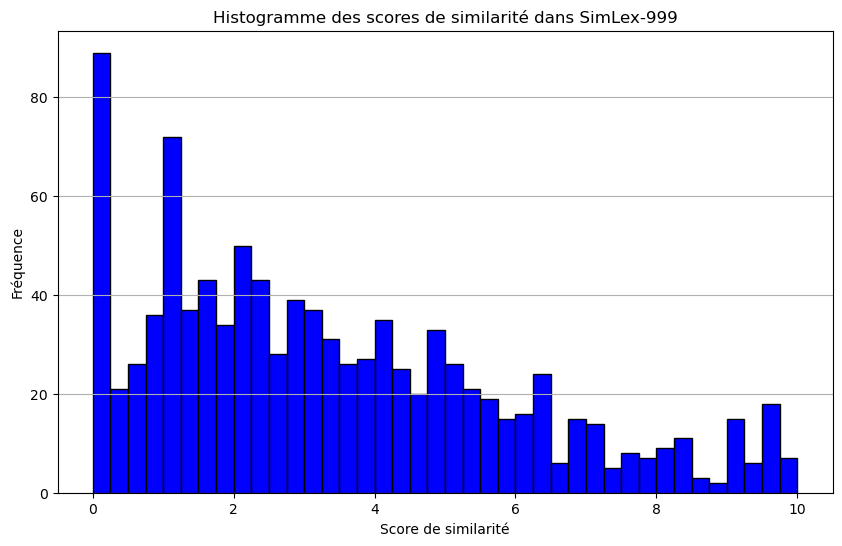

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(evaluation_simlex['score'], bins=40, color='blue', edgecolor='black')
plt.title('Histogramme des scores de similarité dans SimLex-999')
plt.xlabel('Score de similarité')
plt.ylabel('Fréquence')
plt.grid(axis='y')
plt.show()

Un score de 0 indique que les 2 mots sont totalements dissemblables du point de vue du modèle, c'est-à-dire qu'ils n'ont pas un sens sémantique proche ou qu'ils ne sont pas souvent utilisés dans des contextes similaires dans le corpus fournit au modèle.

#### 2.2 Corrélation de Spearman


La corrélation de Spearman est une mesure de la relation monotone entre deux variables $x$ et $y$. Elle est comprise entre -1 et 1. Plutôt que de comparer les valeurs brutes des variables, elle compare leurs rangs. Elle est calculée comme suit :
$$\rho (x, y) = 1 - \frac{6 \sum_{i=1}^n (r_{x_i} - r_{y_i})^2}{n(n^2 - 1)}$$
où $r_{x_i}$ est le rang de la i-ème valeur de la variable x, $r_{y_i}$ est le rang de la i-ème valeur de la variable y, $n$ est le nombre total de paires d'observations $(x, y)$.

Les rangs sont attribués en ordonnant les valeurs de chaque variable du plus petit au plus grand. La plus petite valeur reçoit le rang 1, la suivante le rang 2, et ainsi de suite.

##### Expliquez pourquoi on utilise la corrélation de Spearman plutôt que la corrélation entre les valeurs des variables. (3 points)


La corrélation de Spearman est préférée à la corrélation entre les valeurs des variables car elle est plus robuste à la présence d'outliers. En effet, étant donné que cette corrélation se base sur le rang des valeurs plutôt que les valeurs elles-mêmes, elle permet de réduire l'influence de ces valeurs extrêmes. Par ailleurs, la corrélation de Spearman permet de mesurer la force et la direction d'une relation monotone (une relation ou à mesure qu'une variable augmente, l'autre augmente ou diminue de manière cohérente mais pas nécessairement de manière linéaire), ce qu'une simple corrélation ne permet pas de faire.

#### 2.3 Implémentation de la corrélation de Spearman (2 points)

Complétez la fonction suivante pour calculer la corrélation de Spearman entre deux listes de valeurs.

In [12]:
def spearman_rank_correlation(x, y):
    """
    Calcule la corrélation de Spearman entre deux listes de valeurs.

    Args:
        x   : list of float
        y   : list of float

    Returns:
    La corrélation de Spearman entre les deux listes (float). 
    """

    # Transformation de x en DataFrame
    x_df = pd.DataFrame(x, columns=['value'])
    x_df['rank'] = x_df['value'].rank() # Obtenir le rang
   
    # Transformation de y en DataFrame
    y_df = pd.DataFrame(y, columns=['value'])
    y_df['rank'] = y_df['value'].rank() # Obtenir le rang
    
    # Calcul de la somme des différences des rangs au carré
    sum_diff_ranks = 0
    n  = len(x_df)
    for i in range(n) : 
        sum_diff_ranks += (x_df.iloc[i]['rank'] - y_df.iloc[i]['rank'])**2
        
    # Calcul de la corrélation de Spearman
    spearman_corr = 1 - 6*(sum_diff_ranks)/(n * (n**2 -1))
    
    return spearman_corr

#### 2.4 Évaluation du modèle GloVe (2 points)


Retrouvez les plongements du modèle GloVe de tous les mots du jeu de données SimLex-999, puis calculez la similarité cosinus entre les paires.

Calculez ensuite la corrélation de Spearman entre les scores de simlex et les similarités cosinus obtenues et affichez-la.

In [13]:
pairs = evaluation_simlex[['word 1', 'word 2', 'score']].values.tolist()

similarities = []
simlex_scores = []

for word1, word2, score in pairs: # Pour chaque paire de Simlex
    if word1 in glove_word_to_index and word2 in glove_word_to_index:
        embedding1 = glove_embeddings[glove_word_to_index[word1]] # Récupérer la représentation de word 1
        embedding2 = glove_embeddings[glove_word_to_index[word2]] # Récupérer la représentation de word 2
        
        cosine_sim = cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item() # Calcul de la similarité cosinus entre les deux paires
        similarities.append(cosine_sim) # Stocker la similarité
        simlex_scores.append(score) #Stocker le score


spearman_corr = spearman_rank_correlation(similarities, simlex_scores) # Calcul de la corrélation de Spearman

print(f"Corrélation de Spearman: {spearman_corr:.2f}")

Correlation de Spearman: 0.29


Résultat attendu: 0.29

#### 2.5 Interprétation du résultat (3 points)

Qu'est ce que ce nombre représente et que peut-on en conclure sur la qualité des plongements GloVe (2 conclusions) ?

Ce nombre représente à quel point on peut représenter la corrélation entre la similarité cosinus de deux mots et leur score tel que défini par SimLex par une relation monotone. Dans ce cas ci, la valeur est proche de 0, ce qui suggère qu'il y a une faible relation monotone entre les 2 scores. On peut tirer les conclusions suivantes sur la qualité des plongements GloVe:

1. Une corrélation de 0.29 montre que les plongements GloVe capturent en partie la similarité sémantique entre les mots, mais de manière imparfaite. Autrement dit, même si certaines paires de mots qui sont jugées similaires par SimLex-999 ont des similarités cosinus élevées dans GloVe, cela n’est pas systématique pour toutes les paires.

2. Les plongements de GloVe, bien qu'utiles, ne réflètent pas certaines nuances sémantiques plus subtiles, notamment celles capturées par des évaluations humaines comme SimLex-999.GloVe repose sur des statistiques de co-occurrences de mots, ce qui peut mener à des associations sémantiques erronées, car des mots qui apparaissent souvent ensemble ne sont pas forcément similaires en terme de sens.

### 3. Description de la méthode contrastive (33 Points)

Nous allons maintenant implémenter une méthode contrastive de plongements de mots. Elle vise à améliorer les plongements lexicaux de mots en tenant compte des synonymes et antonymes. 

Notre modèle se basera simplement sur une matrice de plongements de mots, qui associe à chaque mot un vecteur de plongement.

L'idée est d'entraîner ce modèle à rapprocher les plongements de synonymes et d'éloigner ceux d'antonymes.

La cellule suivante définit le modèle et ses attributs.

In [14]:
class ContrastiveWordEmbeddingModel(nn.Module):
    def __init__(self, embeddings, device='cpu', margin_plus=0.6, margin_minus=0., regularization=1e-9):
        super(ContrastiveWordEmbeddingModel, self).__init__()
        
        self.device = device

        # Hyperparamètres pour les fonctions de coût
        self.margin_plus = margin_plus
        self.margin_minus = margin_minus
        self.regularization = regularization
        
        # Initialisation des plongements de mots
        self.embeddings = nn.Embedding.from_pretrained(embeddings.detach().clone(), freeze=False).to(self.device)
        self.original_embeddings = nn.Embedding.from_pretrained(embeddings.detach().clone(), freeze=True).to(self.device)


#### 3.1 Création des négatifs

Pendant l'entraînement, au lieu de traiter tout le jeu d'entraînement d'un coup, nous allons avoir des lots (batchs) de paires de synonymes $B_S$ et d'antonymes $B_A$.

Dans un lot de synonymes, on définit le négatif d'un mot comme le mot du lot le plus proche qui n'est pas dans la même paire. Intuitivement, c'est le mot que le modèle devrait confondre le plus avec le synonyme. Similairement, dans un lot d'antonymes, on définit le négatif d'un mot comme le mot du lot le plus éloigné qui n'est pas dans la même paire.

On répète ce processus pour chaque mot de chaque paire de synonymes et d'antonymes.

*Attention, un mot peut apparaître plusieurs fois dans un lot avec des synonymes ou antonymes différents, et il ne peut être le négatif d'aucun de ses synonymes, ou antonymes.*

##### 3.1.1 Exemple pour illustrer l'implémentation

Prenons un exemple avec un lot $B_S$ de synonymes de taille 3. On veut construire le lot de négatifs $T_S$

$B_S$:
- (arbre, plante)
- (voiture, véhicule)
- (arbre, buisson)

On a 5 mots uniques dans le lot: arbre, plante, voiture, véhicule, buisson. Supposons que la matrice de similarité cosinus soit la suivante :

|       | arbre | plante | voiture | véhicule | buisson |
|-------|-------|--------|--------|----------|---------|
| arbre | 1     | 0.8    | 0.1    | 0.2      | 0.9     |
| plante| 0.8   | 1      | 0.3    | 0.4      | 0.7     |
| voiture| 0.1  | 0.3    | 1      | 0.9      | 0.2     |
| véhicule| 0.2 | 0.4    | 0.9    | 1        | 0.3     |
| buisson| 0.9  | 0.7    | 0.2    | 0.3      | 1       |


On commence par calculer les voisins de chaque mot du lot $B_S$. Le voisin d'un mot $m$ est défini comme tout mot qui apparait dans au moins une paire avec $m$ dans $B_S$. Un mot est aussi considéré comme son propre voisin.

- voisins de arbre : arbre, plante, buisson
- voisins de plante : plante, arbre
- voisins de voiture : voiture, véhicule
- voisins de véhicule : véhicule, voiture
- voisins de buisson : buisson, arbre

Après avoir masqué les voisins, la matrice est :

|       | arbre | plante | voiture | véhicule | buisson |
|-------|-------|--------|--------|----------|---------|
| arbre | -inf  | -inf   | 0.1    | 0.2      | -inf    |
| plante| -inf  | -inf   | 0.3    | 0.4      | 0.7     |
| voiture| 0.1  | 0.3    | -inf   | -inf     | 0.2     |
| véhicule| 0.2 | 0.4    | -inf   | -inf     | 0.3     |
| buisson| -inf | 0.7    | 0.2    | 0.3      | -inf    |

Pour calculer les négatifs, on prend le maximum de chaque ligne (donc le mot le plus similaire qui n'est pas un voisin) :

Ici,
- le négatif d'arbre est véhicule
- le négatif de plante est buisson
- le négatif de voiture est plante
- le négatif de véhicule est plante
- le négatif de buisson est plante

En reprenant le batch $B_S$:
- (arbre, plante)
- (voiture, véhicule)
- (arbre, buisson)

$T_S$ sera composé de paires composées du négatif de chaque élément de $B_S$ :

$B_S$ -> $T_S$
- (arbre, plante) $\rightarrow$ (véhicule, buisson), car le négatif d'arbre est véhicule et le négatif de plante est buisson
- (voiture, véhicule) $\rightarrow$ (plante, plante), car le négatif de voiture est plante et le négatif de véhicule est plante
- (arbre, buisson) $\rightarrow$ (véhicule, plante), car le négatif d'arbre est véhicule et le négatif de buisson est plante

$T_S$ sera donc : 
- (véhicule, buisson)
- (plante, plante)
- (véhicule, plante)

##### 3.1.2 Implémentez la fonction `prepare_neighbors` qui renvoit la liste des voisins de chaque mot dans le lot. (4 points)

Les voisins d'un mot $m$ sont tous les mots du lot qui apparaissent dans au moins une paire avec $m$. Utilisez les bons indices (indice dans la matrice d'embeddings et indice dans le lot). Le résultat est une liste de liste de voisins, où `neighbors[i]` est la liste des voisins du mot `i` dans le lot.

In [15]:
def prepare_neighbors(index_pairs, unique_idx, index_to_idx):
    """
    Prépare les voisins pour chaque mot dans les paires de mots.
    
    Args : 
        index_pairs     : torch.Tensor de seconde dimension 2
        Tensor contenant les indices des embeddings des mots dans le vocabulaire. 
        Des indices qui sont reliés ensemble par une ligne dans ce tenseur ont 
        une relation sémantique entre eux (synonymes ou antonymes).

        unique_idx      : set
        Ensemble de tous les indices qui sont mentionnés dans la liste `index_pairs`.
        
        index_to_idx    : dict
        Dictionnaire associant un indice mentionné dans `index_pairs` à son indice dans
        la liste qui sera retournée. Par exemple, si dans ce dictionnaire, la clé 4 est
        associée à la valeur 12, cela veut dire que les voisins du mot 4 dans le vocabulaire
        seront retournés à l'indice 12 dans la liste de retour.

    Returns:
    Une liste où chaque élément est une liste des indices des voisins pour chaque mot (l'indice dans la liste correspond à l'indice unique).
    """

    # Initialisation de la liste
    neighbors = [[] for _ in range(len(unique_idx))]
    
    word_pairs = index_pairs.tolist()
    
    for word1, word2 in word_pairs: # pour chaque paire word1/word2
        idx1 = index_to_idx[word1]
        idx2 = index_to_idx[word2]
        
        neighbors[idx1].append(idx1) # word1 est son propre voisin
        neighbors[idx1].append(idx2) # word2 est voisin de word1
        
        neighbors[idx2].append(idx2) # word2 est son propre voisin
        neighbors[idx2].append(idx1) # word1 est voisin de word2

    return neighbors

In [16]:
# Exemple
index_pairs = torch.tensor([[0, 12], [12, 31], [53, 4]])
unique_idx = {0, 4, 12, 31, 53}
index_to_idx = {0: 0, 4: 1, 12: 2, 31: 3, 53: 4}
print(prepare_neighbors(index_pairs, unique_idx, index_to_idx))


[[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]


Réponse attendue

`[[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]`

##### 3.1.3 Implémentez la fonction `select_negatives` qui renvoit un dictionnaire qui associe à chaque élément son négatif. (4 points)

Pour chaque élément du lot, on cherche le voisin le plus proche qui n'est pas le voisin de l'autre élément de la paire.

Utilisez un masque pour cacher, dans la matrice de similarité, les voisins.

La fonction utilise un paramètre `synonym` qui indique si on travaille sur un lot de synonymes ou d'antonymes. En cas de synonymes, on cherche le voisin le plus proche qui n'est pas un voisin de l'autre élément de la paire. En cas d'antonymes, on cherche le voisin le plus éloigné qui n'est pas un voisin de l'autre élément de la paire.

In [17]:
def select_negatives(indices, similarity_matrix, neighbors, synonym=True):
    """
    Sélectionne les exemples négatifs à partir de la matrice de similarité et des voisins.

    Args : 
        indices             : torch.Tensor (vocab_size)
        Indices des mots présents dans le vocabulaires
        
        similarity_matrix   : torch.Tensor (vocab_size, vocab_size)
        Matrice de similarité entre tous les mots présents dans le vocabulaire.
        
        neighbors           : list of lists
        Liste des voisins de chaque mot. Par exemple, le premier élément de la liste
        contiendra tous les voisins du mot 0 dans le vocabulaire.

        synonym             : bool, optional (default=True)
        Indique si l'on cherche des négatifs pour les synonymes (True) ou pour les antonymes (False).

    Returns:
    Dictionnaire mappant les mots avec leurs indices de négatifs {mot_index: négatif_index}.
    """

    # Masquage des voisins dans la matrice de similarité

    # Attention : On considère pour le masquage que le mappage des valeurs dans neighbours correspond aux indices de la matrice de similarité
    # (e.g la première liste de neigbours correspond aux voisins du mot représeenté par la première ligne de la matrice de similarité)
    # C'est le cas si :
    # -> index_to_idx utilisé dans prepare_neighbors est de la forme {x0: 0, x1: 1, ..., xn: n} 
    # -> {x0, x1, ..., xn} est la liste ordonnée des indices "indices" donné à cosine_similarity (soit similarity_matrix = cosine_similarity(model.embeddings(indices), model.embeddings(indices))
    
    mask_value = float('-inf') if synonym else float('+inf')

    for index, neighbors_list in enumerate(neighbors):
        for neighbour in neighbors_list:
            similarity_matrix[index][neighbour] = mask_value


    # Création du dictionnaire

    # Attention : On considère pour le création du dictionnaire que l'ordre des valeurs dans indices correspond à l'ordre de la matrice de similarité
    # (e.g le premier élément de indices a sa représentation dans la première ligne de la matrice de similarité)
    # C'est le cas si :
    # -> la liste indices "indices" est donnée à cosine_similarity (soit similarity_matrix = cosine_similarity(model.embeddings(indices), model.embeddings(indices))

    result_dict = {
        index : (similarity_matrix[i].argmax() if synonym else similarity_matrix[i].argmin()).item() # Association de chaque indice à l'indice du voisin le plus proche (synonyme) ou le plus éloigné (antonyme)
        for i, index in enumerate(indices.tolist())
    }

    return result_dict

In [18]:
# Exemple
indices = torch.tensor([0, 1, 2, 3, 4])
neighbors = [[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]

similarity_matrix = torch.tensor([
    [ 1.0000, -0.4263, -0.7167, -0.9838, -0.5823],
    [-0.4263,  1.0000, -0.1600,  0.5088, -0.3708],
    [-0.7167, -0.1600,  1.0000,  0.7247,  0.5631],
    [-0.9838,  0.5088,  0.7247,  1.0000,  0.4394],
    [-0.5823, -0.3708,  0.5631,  0.4394,  1.0000]
    ])

print(select_negatives(indices, similarity_matrix, neighbors, synonym=True))

{0: 1, 1: 3, 2: 4, 3: 1, 4: 2}


Réponse attendue

`{0: 1, 1: 3, 2: 4, 3: 1, 4: 2}`

##### 3.1.4 Implémentez la fonction `run_negative_extraction` qui prépare les paires de synonymes et d'antonymes et appelle `prepare_neighbors` et `select_negatives`. (4 points)

Préparez les indices uniques des mots du batch, calculez la similarité des mots, et appelez `prepare_neighbors` et `select_negatives`.

In [31]:
def run_negative_extraction(model, index_pairs, synonym=True):
    """
    Extrait les exemples négatifs pour un ensemble de paires de mots.

    Args :
        index_pairs : torch.Tensor de seconde dimension 2
        Contient les indices des mots.

        synonym     : bool, optional (default=True)
        Indique si l'on cherche des négatifs pour les synonymes (True) ou pour les antonymes (False).

    Returns:
    Dictionnaire mappant les indices des mots avec leurs indices de négatifs {mot_index: négatif_index}.
    """

    # Préparation des paramètres de prepare_neighbors
    unique_ids = set([idx.item() for row in index_pairs for idx in row]) # liste des indices uniques
    index_to_ids = {idx: i for i, idx in enumerate(sorted(list(unique_ids)))} # dictionnaire de mappage vers les indices de la matrice de similarité (clés, qui correspondent aux ids des mots, triées par ordre croissant)


    # Préparation des paramètres de select_negatives
    indices = torch.tensor(sorted(list(unique_ids)), device = model.device) # liste d'indices (valeurs, qui correspondent aux ids des mots, triées par ordre croissant)
    embeddings = model.embeddings(indices)
    similarity_matrix = cosine_similarity(embeddings, embeddings) # matrice de similarité (les lignes et les colonnes donc triées par ordre croissant des ids des mots)

    # Appels des deux fonctions
    neighbors = prepare_neighbors(index_pairs, unique_ids, index_to_ids)
    negatives = select_negatives(indices, similarity_matrix, neighbors, synonym)

    return negatives

#### 3.2 Fonctions de coût

Pour chaque paire de synonymes $(x^l, x^r)$ *pour x left et x right* dans le lot $B_S$, nous trouvons un négatif $(t^l, t^r)$ ce qui constitue le lot $T_S$:
- $ t^l $ est le mot dans le lot le plus proche de $ x^l $ mais qui n'est pas $ x^r $.
- $ t^r $ est le mot dans le lot le plus proche de $ x^r $ mais qui n'est pas $ x^l $.

De même, pour chaque paire d'antonymes $(x^l, x^r)$ dans le lot $B_A$, nous trouvons un négatif $(t^l, t^r)$ ce qui constitue le lot $T_A$:
- $ t^l $ est le mot dans le lot le plus éloigné de $ x^l $ mais qui n'est pas $ x^r $.
- $ t^r $ est le mot dans le lot le plus éloigné de $ x^r $ mais qui n'est pas $ x^l $.


Comparer un mot à son synonyme (ou antonyme) et à son négatif permet d'entraîner le modèle sur des exemples difficiles qui forcent le modèle à apprendre des représentations plus robustes.

Il y aura trois fonctions de coût :
1. **Attraction** : Attire les synonymes plus proches les uns des autres.
2. **Répulsion** : Repousse les antonymes plus loin les uns des autres.
3. **Régularisation** : Évite que les plongements ne s'éloignent trop de ceux du modèle pré-entraîné.

Les fonctions de coût sont définies comme suit, en sommant sur `i`, les paires de synonymes et d'antonymes dans les lots $B_S$ et $B_A$ :

1. **Attraction** :
$$ S(B_S, T_S) = \sum_{i=1}^{|B_S|} \left[ \max \left(0, \delta_{syn} + x_i^l t_i^l - x_i^l x_i^r \right) + \max \left( 0, \delta_{syn} + x_i^r t_i^r - x_i^l x_i^r \right) \right] $$

1. **Répulsion** :
$$ A(B_A, T_A) = \sum_{i=1}^{|B_A|} \left[ \max \left(0, \delta_{ant} + x_i^l x_i^r - x_i^l t_i^l \right) + \max \left( 0, \delta_{ant} + x_i^r x_i^l - x_i^r t_i^r \right) \right] $$

1. **Régularisation** :
$$ R(B_S, B_A) = \sum_{x_i \in V(B_S \cup B_A)} \lambda_{reg} \| \hat{x}_i - x_i \|^2 $$

La fonction de coût totale est la somme de ces trois termes :
$$ C(B_S, T_S, B_A, T_A) = S(B_S, T_S) + A(B_A, T_A) + R(B_S, B_A) $$

$\delta_{syn}$, $\delta_{ant}$ et $\lambda_{reg}$ sont des hyperparamètres.

Avec l'exemple précédent, prenons
> + $x_i^l$ : voiture
> + $x_i^r$: véhicule
> + $t_i^l$: plante
> 
> On veut que voiture et véhicule aient un plus grand produit scalaire que voiture et plante, donc que $\delta_{syn} + x_i^l t_i^l - x_i^l x_i^r <0$, et donc que $S$ soit minimisé. De même pour la deuxième partie de l'équation, symmétrique, avec le 2nd élément du couple.

##### 3.2.1 Implémentez la fonction `synonym_cost` qui calcule la fonction de coût d'attraction (sur les paires de synonymes). (5 points)

$$ S(B_S, T_S) = \sum_{i=1}^{|B_S|} \left[ \max \left(0, \delta_{syn} + x_i^l t_i^l - x_i^l x_i^r \right) + \max \left( 0, \delta_{syn} + x_i^r t_i^r - x_i^l x_i^r \right) \right] $$

Le membre de gauche pénalise si le mot de gauche est plus éloigné de son négatif que de son synonyme. De même, le membre de droite pénalise si le mot de gauche est plus éloigné de son négatif que de son synonyme.


In [84]:
def synonym_cost(model, synonym_pairs, synonym_negatives):
    """
    Calcule le coût d'attraction pour les paires de synonymes.

    synonym_pairs: liste de tuples d'indices de paires de synonymes
    synonym_negatives: dictionnaire de mots avec leurs négatifs {mot_index: négatif_index}

    Returns:
    torch.Tensor, coût total pour les paires de synonymes
    """

    # Indices des synonymes et leurs négatifs
    indices_left = torch.tensor([pair[0] for pair in synonym_pairs], device=model.device)
    indices_right = torch.tensor([pair[1] for pair in synonym_pairs], device=model.device)
    indices_negatives_left = torch.tensor([synonym_negatives[pair[0].item()] for pair in synonym_pairs], device=model.device)
    indices_negatives_right = torch.tensor([synonym_negatives[pair[1].item()] for pair in synonym_pairs], device=model.device)

    # Embeddings (de dimension (batch_size, embedding_dim))
    x_l = model.embeddings(indices_left)
    x_r = model.embeddings(indices_right)
    t_l = model.embeddings(indices_negatives_left)
    t_r = model.embeddings(indices_negatives_right)

    # Calcul du coût
    x_l_t_l = torch.sum(x_l * t_l, dim=1) # dot product entre chaque ligne
    x_l_x_r = torch.sum(x_l * x_r, dim=1) # dot product entre chaque ligne
    x_r_t_r = torch.sum(x_r * t_r, dim=1) # dot product entre chaque ligne

   
    cost_1 = torch.relu(x_l_t_l - x_l_x_r + model.margin_plus) # max pour chaque ligne
    cost_2 = torch.relu(x_r_t_r - x_l_x_r + model.margin_plus) # max pour chaque ligne
    total_cost = cost_1 + cost_2 # Tensor de dimension (batch_size, 1)

    synonym_cost = torch.sum(total_cost) # Somme sur i
    
    return synonym_cost

##### 3.2.2 Implémentez la fonction `antonym_cost` qui calcule la fonction de coût de répulsion (sur les paires d'antonymes). (5 points)

$$ A(B_A, T_A) = \sum_{i=1}^{|B_A|} \left[ \max \left(0, \delta_{ant} + x_i^l x_i^r - x_i^l t_i^l \right) + \max \left( 0, \delta_{ant} + x_i^r x_i^l - x_i^r t_i^r \right) \right] $$

Le membre de gauche pénalise si le mot de gauche est plus éloigné de son antonyme que de son négatif. De même, le membre de droite pénalise si le mot de gauche est plus éloigné de son antonyme que de son négatif.

In [85]:
def antonym_cost(model, antonym_pairs, antonym_negatives):
    """
    Calcule le coût de répulsion pour les paires d'antonymes.

    antonym_pairs: liste de tuples d'indices de paires d'antonymes
    antonym_negatives: dictionnaire de mots avec leurs négatifs {mot_index: négatif_index}

    Returns:
    torch.Tensor, coût total pour les paires d'antonymes
    """

    # Indices des antonymes et leurs négatifs
    indices_left = torch.tensor([pair[0] for pair in antonym_pairs], device=model.device)
    indices_right = torch.tensor([pair[1] for pair in antonym_pairs], device=model.device)
    indices_negatives_left = torch.tensor([antonym_negatives[pair[0].item()] for pair in antonym_pairs], device=model.device)
    indices_negatives_right = torch.tensor([antonym_negatives[pair[1].item()] for pair in antonym_pairs], device=model.device)

    # Embeddings (de dimension (batch_size, embedding_dim))
    x_l = model.embeddings(indices_left)
    x_r = model.embeddings(indices_right)
    t_l = model.embeddings(indices_negatives_left)
    t_r = model.embeddings(indices_negatives_right)

    # Calcul du coût
    x_l_x_r = torch.sum(x_l * x_r, dim=1)  # dot product entre chaque ligne
    x_l_t_l = torch.sum(x_l * t_l, dim=1)  # dot product entre chaque ligne
    x_r_t_r = torch.sum(x_r * t_r, dim=1)  # dot product entre chaque ligne

    cost_1 = torch.relu(x_l_x_r - x_l_t_l + model.margin_minus) # max pour chaque ligne
    cost_2 = torch.relu(x_l_x_r - x_r_t_r + model.margin_minus) # max pour chaque ligne
    total_cost = cost_1 + cost_2 # Tensor de dimension (batch_size, 1)

    antonym_cost = torch.sum(total_cost) # Somme sur i
    
    return antonym_cost

##### 3.2.3 Implémentez la fonction `regularization_cost` qui calcule la fonction de coût de régularisation. (4 points)

$$ R(B_S, B_A) = \sum_{x_i \in V(B_S \cup B_A)} \lambda_{reg} \| \hat{x}_i - x_i \|^2 $$

In [86]:
def regularization_cost(model, synonym_pairs, antonym_pairs):
    """
    Calcule le coût de régularisation pour les paires de synonymes et antonymes.

    synonym_pairs: liste de tuples d'indices de paires de synonymes
    antonym_pairs: liste de tuples d'indices de paires d'antonymes

    Returns:
    torch.Tensor, coût total de régularisation
    """

    # Ensemble des indices
    indexes = set([syn_index for pair in synonym_pairs for syn_index in pair] + 
                   [ant_index for pair in antonym_pairs for ant_index in pair])
    index_tensor = torch.tensor(list(indexes), device=model.device)

    # Embeddings
    x_hat = model.original_embeddings(index_tensor)
    x = model.embeddings(index_tensor)

    # Calcul du coût
    regularization_cost = model.regularization * torch.sum(torch.norm(x_hat - x, p=2, dim=1)**2)
    
    return regularization_cost

#### 3.3 Mise en place
##### 3.3.1 Implémentez la fonction `forward` qui utilise les fonctions définies plus tôt pour calculer le coût total. (4 points)

La fonction prend en entrée un lot de synonymes et un lot d'antonymes, c'est-à-dire des paires de synonymes et des paires d'antonymes.

Vous devez trouver les négatifs de tous les mots des lots au moyen de votre fonction  run_negative_extraction puis calculer la fonction de coût totale.

In [87]:
def forward(model, synonym_pairs, antonym_pairs):
    """
    Fonction forward pour calculer le coût total.

    Args : 
        synonym_pairs   : 
        Liste de tuples d'indices de paires de synonymes

        antonym_pairs   : 
        Liste de tuples d'indices de paires d'antonymes

    Returns:
    Tenseur contenant le coût total (attraction, répulsion et régularisation)
    """

    # Calcul de tous les négatifs
    neg_syn_dict = run_negative_extraction(model, synonym_pairs)
    neg_ant_dict = run_negative_extraction(model, antonym_pairs, synonym=False)

    # Calcul du cout total
    cost  = synonym_cost(model, synonym_pairs, neg_syn_dict) + antonym_cost(model, antonym_pairs, neg_ant_dict) + regularization_cost(model, synonym_pairs, antonym_pairs)
    return cost

#### 3.3.2 Évaluation (3 points)

Utilisez la fonction `spearman_rank_correlation` pour compléter la fonction d'évaluation `evaluate` qui exécute le modèle sur le jeu d'évaluation et calcule la corrélation de Spearman entre les scores prédits et réels.

Utilisez `torch.no_grad()` pour éviter de stocker les gradients.

In [88]:
def evaluate(model, eval_data, word_to_index):
    """
    Calclue les prédictions du modèle sur le jeu d'évaluation puis la corrélation de Spearman entre les scores prédits et réels.

    model: modèle de plongements de mots
    eval_data: pd.DataFrame
    word_to_index: dict

    Returns:
    float, la corrélation de Spearman entre les scores prédits par le modèle et réels.
    """
    # Mettre le modèle en mode évaluation
    model.eval()
    device = model.device

    # Obtenir les indices des paires de mots de eval_data
    word_pairs = list(zip(eval_data['word 1'], eval_data['word 2']))
    eval_indices = [(word_to_index[w1], word_to_index[w2]) for w1, w2 in word_pairs if w1 in word_to_index and w2 in word_to_index]

    # Scores réels
    real_scores = eval_data['score'].values

    # Scores prédits
    predicted_scores = []

    with torch.no_grad():  
        for id_word1, id_word2 in eval_indices:
            word1_embedding = model.embeddings(torch.tensor(id_word1, device=device)) # Récupérer la représentation de word 1 issue du modèle
            word2_embedding = model.embeddings(torch.tensor(id_word2, device=device)) # Récupérer la représentation de word 2 issue du modèle
            cosine_sim = cosine_similarity(word1_embedding.unsqueeze(0), word2_embedding.unsqueeze(0)).item() # Calcul de la similarité cosinus entre les deux paires
            predicted_scores.append(cosine_sim) # Stocker la similarité
            
    return spearman_rank_correlation(real_scores, predicted_scores) # Calculer la corrélation de Spearman

### 4. Entraînement de zéro (16 Points)

Nous allons maintenant entraîner le modèle de zéro, sans utiliser les plongements GloVe pré-entraînés. Ensuite, dans la partie 5, nous entraînerons le modèle en l'initialisant avec les plongements GloVe pré-entraînés.

In [89]:
# Hyperparamètres, optimiseur et DataLoader

BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 5e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.cuda.empty_cache()
gc.collect()

train_syn_tensor = data_to_tensor(train_synonyms, glove_word_to_index)
train_ant_tensor = data_to_tensor(train_antonyms, glove_word_to_index)

syn_data_loader = DataLoader(train_syn_tensor, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
ant_data_loader = DataLoader(train_ant_tensor, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

#### 4.1 Complétez la cellule suivante pour créer le modèle de zéro `model_zero`, à partir d'une matrice de plongements aléatoire. (1 point)

In [97]:
model_zero = None
random_seed = 0
random_generator = torch.Generator(device=device).manual_seed(random_seed)

embeddings_size = glove_embeddings.size()
random_init_embeddings = torch.randn(embeddings_size, generator=random_generator, device=device)

model_zero = ContrastiveWordEmbeddingModel(random_init_embeddings, device=device)

optimizer = optim.Adam(model_zero.parameters(), lr=LEARNING_RATE)

#### 4.2 Entraînez le modèle sur le jeu des paires de synonymes et d'antonymes. (6 points)

N'oubliez pas que l'entraînement se fait sur les synonymes et antonymes et que l'évaluation se fait sur SimLex-999.

À défaut d'avoir un jeu de validation, on observe les résultats sur le corpus de test : SimLex-999. Ceci n’est fait qu’à titre illustratif pour voir l'évolution de l'apprentissage. Il ne faut pas faire de choix pour l’entrainement à partir des résultats sur le corpus de test.

*Note : Les jeux de synonymes et d'antonymes n'ont pas la même taille. Une époque (epoch) correspond à une itération sur le jeu de données le plus petit.*

In [98]:
spearman_corr = evaluate(model_zero, evaluation_simlex, glove_word_to_index)
print(f'Before training, Spearman Correlation: {spearman_corr:.4f}')

losses = []  # Perte moyenne à chaque epoch
spearman_correlations = []  # Corrélation de Spearman à chaque epoch

for epoch in tqdm(range(NUM_EPOCHS)):
    model_zero.train() # Mettre le modèle en mode entrainement
    total_loss = 0.0
    num_batches = 0

    for syn_batch, ant_batch in zip(syn_data_loader, ant_data_loader):
        syn_batch = syn_batch.to(device)
        ant_batch = ant_batch.to(device)

        optimizer.zero_grad() # Réinitialisation des gradients
        loss = forward(model_zero, syn_batch, ant_batch) # Appel de forward
        loss.backward() # Calcul des gradients
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1

    # Perte moyenne pour cet epoch
    average_loss = total_loss / num_batches
    losses.append(average_loss) 
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Total Loss: {total_loss:.4f}, Average Loss: {average_loss:.4f}")
    
    # Corrélation pour cet epoch
    spearman_corr = evaluate(model_zero, evaluation_simlex, glove_word_to_index)
    spearman_correlations.append(spearman_corr)
    print(f'Epoch {epoch + 1}, Spearman Correlation: {spearman_corr:.4f}')

spearman_corr = evaluate(model_zero, evaluation_simlex, glove_word_to_index)
print(f'After training, Spearman Correlation: {spearman_corr:.4f}')

Before training, Spearman Correlation: -0.0256


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Total Loss: 464674.1747, Average Loss: 2498.2483


  5%|▌         | 1/20 [00:10<03:28, 10.99s/it]

Epoch 1, Spearman Correlation: 0.0122
Epoch 2/20, Total Loss: 325929.9333, Average Loss: 1752.3115


 10%|█         | 2/20 [00:23<03:35, 11.99s/it]

Epoch 2, Spearman Correlation: 0.0398
Epoch 3/20, Total Loss: 282177.8497, Average Loss: 1517.0852


 15%|█▌        | 3/20 [00:37<03:36, 12.72s/it]

Epoch 3, Spearman Correlation: 0.0580
Epoch 4/20, Total Loss: 256658.2078, Average Loss: 1379.8828


 20%|██        | 4/20 [00:49<03:23, 12.72s/it]

Epoch 4, Spearman Correlation: 0.0671
Epoch 5/20, Total Loss: 239509.7254, Average Loss: 1287.6867


 25%|██▌       | 5/20 [01:01<03:05, 12.38s/it]

Epoch 5, Spearman Correlation: 0.0812
Epoch 6/20, Total Loss: 224688.1909, Average Loss: 1208.0010


 30%|███       | 6/20 [01:13<02:49, 12.13s/it]

Epoch 6, Spearman Correlation: 0.0867
Epoch 7/20, Total Loss: 211741.2958, Average Loss: 1138.3941


 35%|███▌      | 7/20 [01:25<02:37, 12.15s/it]

Epoch 7, Spearman Correlation: 0.0913
Epoch 8/20, Total Loss: 194744.0225, Average Loss: 1047.0109


 40%|████      | 8/20 [01:38<02:27, 12.33s/it]

Epoch 8, Spearman Correlation: 0.0991
Epoch 9/20, Total Loss: 181575.0491, Average Loss: 976.2099


 45%|████▌     | 9/20 [01:51<02:17, 12.51s/it]

Epoch 9, Spearman Correlation: 0.1083
Epoch 10/20, Total Loss: 162228.1488, Average Loss: 872.1943


 50%|█████     | 10/20 [02:03<02:05, 12.55s/it]

Epoch 10, Spearman Correlation: 0.1200
Epoch 11/20, Total Loss: 147995.5013, Average Loss: 795.6747


 55%|█████▌    | 11/20 [02:16<01:51, 12.43s/it]

Epoch 11, Spearman Correlation: 0.1234
Epoch 12/20, Total Loss: 129604.4897, Average Loss: 696.7983


 60%|██████    | 12/20 [02:32<01:50, 13.75s/it]

Epoch 12, Spearman Correlation: 0.1314
Epoch 13/20, Total Loss: 120445.9542, Average Loss: 647.5589


 65%|██████▌   | 13/20 [02:45<01:33, 13.34s/it]

Epoch 13, Spearman Correlation: 0.1382
Epoch 14/20, Total Loss: 103424.7589, Average Loss: 556.0471


 70%|███████   | 14/20 [02:56<01:17, 12.86s/it]

Epoch 14, Spearman Correlation: 0.1428
Epoch 15/20, Total Loss: 94283.1557, Average Loss: 506.8987


 75%|███████▌  | 15/20 [03:08<01:02, 12.52s/it]

Epoch 15, Spearman Correlation: 0.1478
Epoch 16/20, Total Loss: 86408.1632, Average Loss: 464.5600


 80%|████████  | 16/20 [03:20<00:49, 12.37s/it]

Epoch 16, Spearman Correlation: 0.1542
Epoch 17/20, Total Loss: 76061.9737, Average Loss: 408.9353


 85%|████████▌ | 17/20 [03:32<00:36, 12.30s/it]

Epoch 17, Spearman Correlation: 0.1622
Epoch 18/20, Total Loss: 69063.9828, Average Loss: 371.3117


 90%|█████████ | 18/20 [03:44<00:24, 12.24s/it]

Epoch 18, Spearman Correlation: 0.1667
Epoch 19/20, Total Loss: 60888.6505, Average Loss: 327.3583


 95%|█████████▌| 19/20 [03:57<00:12, 12.31s/it]

Epoch 19, Spearman Correlation: 0.1739
Epoch 20/20, Total Loss: 54897.8191, Average Loss: 295.1496


100%|██████████| 20/20 [04:10<00:00, 12.51s/it]

Epoch 20, Spearman Correlation: 0.1797


After training, Spearman Correlation: 0.1797


#### 4.3 Courbes d'entraînement du modèle de zéro (4 points)

Affichez la perte moyenne sur le jeu d'entraînement et la corrélation de Spearman sur le jeu de validation à chaque époque.

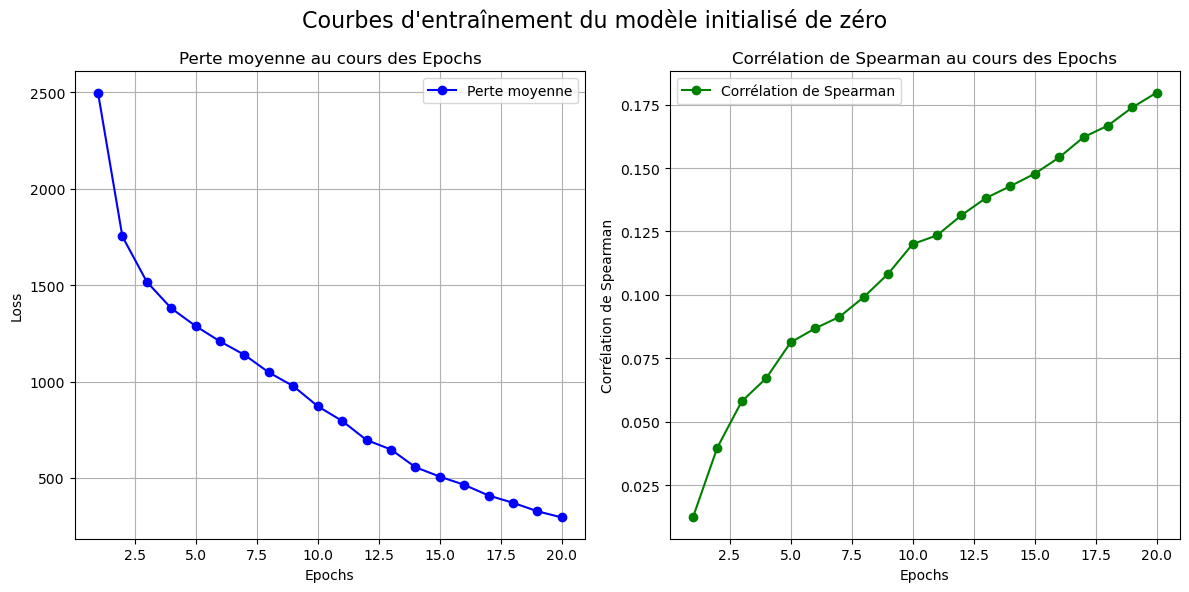

In [110]:
# Affichage des courbes d'entraînement
plt.figure(figsize=(12, 6))
plt.suptitle('Courbes d\'entraînement du modèle initialisé de zéro', fontsize=16)

# Courbe pour la perte moyenne
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), losses, marker='o', color='blue', label='Perte moyenne')
plt.title('Perte moyenne au cours des Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# Courbe pour la corrélation de Spearman
plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), spearman_correlations, marker='o', color='green', label='Corrélation de Spearman')
plt.title('Corrélation de Spearman au cours des Epochs')
plt.xlabel('Epochs')
plt.ylabel('Corrélation de Spearman')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

#### 4.4 Évaluation du modèle de zéro et comparaison avec GloVe (5 points)

Comparez le modèle de zéro après l'entraînement à GloVe (résultat de la partie 2.4) en termes de corrélation de Spearman sur le jeu de validation. Quelle méthode est la plus performante ? Pourquoi ?


La corrélation de Spearman après l'entraînement à GloVe s'élevait à 0.29 tandis qu'elle s'élève à 0.1688 après l'entraînement du modèle de zéro. On peut en conclure que selon cette métrique, GloVe est la plus performante des méthodes parce qu'elle a une valeur plus grande de la corrélation de Sperman, et donc permet potentiellement de mieux représenter la relation entre le score SimLex d'une paire et la similarité cosinus des mots de la paire avec une relation monotone. Le fait que GloVe ait une plus grande corrélation de Spearman plus élevée permert de conclure que ce modèle est meilleur le sens sémantique qu'ils donnent aux mots est plus proche de la réalité que le modèle à zéro.

Vu que le modèle à zéro commence sans informations préalables et présente des performances assez basses, on peut conclure que les informations contenues dans les co-occurences initiales sont assez cruciales pour parvenir à capturer la similarité entre des mots. On observerait donc probalement de meilleures performances en utilisant les plongements de mots obtenus avec GloVe qu'en partant de 0.

### 5. Intérêt de GloVe (18 Points)

Dans la section précédente, nous avons entraîné un modèle de zéro.

Nous allons maintenant évaluer si initialiser le modèle avec les plongements de GloVe permet d'améliorer les performances.

#### 5.1 Initialisation avec GloVe (6 points)

Entraînez le modèle `model_fine_tuned`, mais cette fois en ititialisant directement avec les plongements du modèle pré-entraîné GloVe.

On utilisera Adam comme optimiseur.

In [100]:
model_fine_tuned = None

model_fine_tuned = ContrastiveWordEmbeddingModel(glove_embeddings, device=device) # Initialisation avec Glove
optimizer = optim.Adam(model_fine_tuned.parameters(), lr=LEARNING_RATE)

In [101]:
spearman_corr = evaluate(model_fine_tuned, evaluation_simlex, glove_word_to_index)
print(f'Before training, Spearman Correlation: {spearman_corr:.4f}')

losses_glove = []  # Perte moyenne à chaque epoch
spearman_correlations_glove = []  # Corrélation de Spearman à chaque epoch

for epoch in tqdm(range(NUM_EPOCHS)):
    model_zero.train() # Mettre le modèle en mode entrainement
    total_loss = 0.0
    num_batches = 0

    for syn_batch, ant_batch in zip(syn_data_loader, ant_data_loader):
        syn_batch = syn_batch.to(device)
        ant_batch = ant_batch.to(device)

        optimizer.zero_grad() # Réinitialisation des gradients
        loss = forward(model_fine_tuned, syn_batch, ant_batch) # Appel de forward
        loss.backward() # Calcul des gradients
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1

    # Perte moyenne pour cet epoch
    average_loss = total_loss / num_batches
    losses_glove.append(average_loss) 
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Total Loss: {total_loss:.4f}, Average Loss: {average_loss:.4f}")
    
    # Corrélation pour cet epoch
    spearman_corr = evaluate(model_fine_tuned, evaluation_simlex, glove_word_to_index)
    spearman_correlations_glove.append(spearman_corr)
    print(f'Epoch {epoch + 1}, Spearman Correlation: {spearman_corr:.4f}')

spearman_corr = evaluate(model_fine_tuned, evaluation_simlex, glove_word_to_index)
print(f'After training, Spearman Correlation: {spearman_corr:.4f}')

Before training, Spearman Correlation: 0.2916


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Total Loss: 147460.3706, Average Loss: 792.7977


  5%|▌         | 1/20 [00:11<03:46, 11.94s/it]

Epoch 1, Spearman Correlation: 0.3442
Epoch 2/20, Total Loss: 40925.5716, Average Loss: 220.0300


 10%|█         | 2/20 [00:24<03:43, 12.42s/it]

Epoch 2, Spearman Correlation: 0.3635
Epoch 3/20, Total Loss: 17578.4635, Average Loss: 94.5079


 15%|█▌        | 3/20 [00:36<03:29, 12.32s/it]

Epoch 3, Spearman Correlation: 0.3710
Epoch 4/20, Total Loss: 10635.4265, Average Loss: 57.1797


 20%|██        | 4/20 [00:49<03:16, 12.28s/it]

Epoch 4, Spearman Correlation: 0.3828
Epoch 5/20, Total Loss: 7186.0152, Average Loss: 38.6345


 25%|██▌       | 5/20 [01:01<03:04, 12.30s/it]

Epoch 5, Spearman Correlation: 0.3899
Epoch 6/20, Total Loss: 5639.4634, Average Loss: 30.3197


 30%|███       | 6/20 [01:14<02:53, 12.41s/it]

Epoch 6, Spearman Correlation: 0.3938
Epoch 7/20, Total Loss: 4848.9835, Average Loss: 26.0698


 35%|███▌      | 7/20 [01:27<02:44, 12.62s/it]

Epoch 7, Spearman Correlation: 0.4011
Epoch 8/20, Total Loss: 4049.2482, Average Loss: 21.7702


 40%|████      | 8/20 [01:39<02:31, 12.61s/it]

Epoch 8, Spearman Correlation: 0.4043
Epoch 9/20, Total Loss: 2983.4818, Average Loss: 16.0402


 45%|████▌     | 9/20 [01:52<02:18, 12.56s/it]

Epoch 9, Spearman Correlation: 0.4036
Epoch 10/20, Total Loss: 2893.1934, Average Loss: 15.5548


 50%|█████     | 10/20 [02:04<02:05, 12.53s/it]

Epoch 10, Spearman Correlation: 0.4048
Epoch 11/20, Total Loss: 2553.9425, Average Loss: 13.7309


 55%|█████▌    | 11/20 [02:16<01:52, 12.46s/it]

Epoch 11, Spearman Correlation: 0.4153
Epoch 12/20, Total Loss: 2498.8094, Average Loss: 13.4345


 60%|██████    | 12/20 [02:29<01:39, 12.43s/it]

Epoch 12, Spearman Correlation: 0.4214
Epoch 13/20, Total Loss: 2227.0940, Average Loss: 11.9736


 65%|██████▌   | 13/20 [02:41<01:26, 12.35s/it]

Epoch 13, Spearman Correlation: 0.4207
Epoch 14/20, Total Loss: 2104.1938, Average Loss: 11.3129


 70%|███████   | 14/20 [02:53<01:13, 12.33s/it]

Epoch 14, Spearman Correlation: 0.4216
Epoch 15/20, Total Loss: 1719.9325, Average Loss: 9.2469


 75%|███████▌  | 15/20 [03:06<01:01, 12.32s/it]

Epoch 15, Spearman Correlation: 0.4255
Epoch 16/20, Total Loss: 1807.1827, Average Loss: 9.7160


 80%|████████  | 16/20 [03:18<00:49, 12.30s/it]

Epoch 16, Spearman Correlation: 0.4326
Epoch 17/20, Total Loss: 1791.8592, Average Loss: 9.6337


 85%|████████▌ | 17/20 [03:30<00:37, 12.36s/it]

Epoch 17, Spearman Correlation: 0.4416
Epoch 18/20, Total Loss: 1697.7525, Average Loss: 9.1277


 90%|█████████ | 18/20 [03:43<00:24, 12.41s/it]

Epoch 18, Spearman Correlation: 0.4494
Epoch 19/20, Total Loss: 1696.6773, Average Loss: 9.1219


 95%|█████████▌| 19/20 [03:55<00:12, 12.41s/it]

Epoch 19, Spearman Correlation: 0.4539
Epoch 20/20, Total Loss: 1492.9449, Average Loss: 8.0266


100%|██████████| 20/20 [04:09<00:00, 12.46s/it]

Epoch 20, Spearman Correlation: 0.4549


After training, Spearman Correlation: 0.4549


#### 5.2 Courbes d'entraînement (4 points)

Affichez la perte moyenne sur le jeu d'entraînement et la corrélation de Spearman sur le jeu de validation à chaque époque.

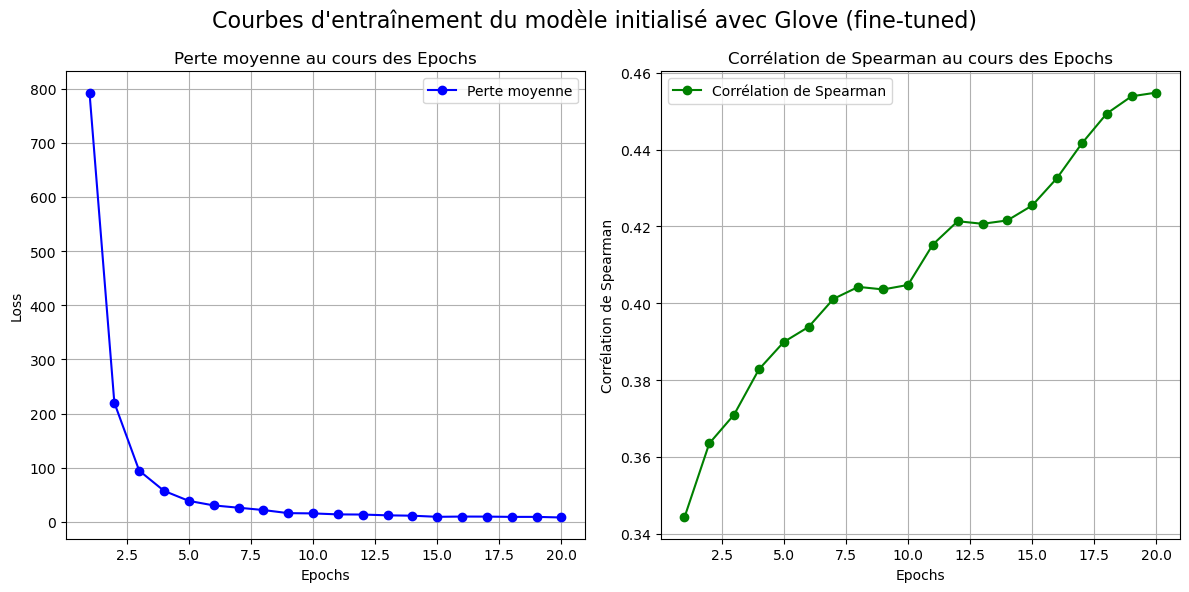

In [112]:
# Affichage des courbes d'entraînement
plt.figure(figsize=(12, 6))
plt.suptitle('Courbes d\'entraînement du modèle initialisé avec Glove (fine-tuned)', fontsize=16)

# Courbe pour la perte moyenne
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), losses_glove, marker='o', color='blue', label='Perte moyenne')
plt.title('Perte moyenne au cours des Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# Courbe pour la corrélation de Spearman
plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), spearman_correlations_glove, marker='o', color='green', label='Corrélation de Spearman')
plt.title('Corrélation de Spearman au cours des Epochs')
plt.xlabel('Epochs')
plt.ylabel('Corrélation de Spearman')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

#### 5.3 Vérification sur un exemple (3 points)

Avec le modèle `model_fine_tuned`, calculez la similarité cosinus entre 'fast' et 'slow' et entre 'fast' et 'rapid'. Commentez les résultats en les comparant avec ceux de la partie 1.4.

In [105]:
words = ['fast', 'slow', 'rapid']

embeddings = []
for word in words:
    embedding = model_fine_tuned.embeddings(torch.tensor(glove_word_to_index[word]).to(device))  # Obtenir l'embedding à partir du modèle
    embeddings.append(embedding)

# Calculer la similarité cosinus entre 'fast' et 'slow'
similarity_fast_slow = cosine_similarity(
    embeddings[0].unsqueeze(0), 
    embeddings[1].unsqueeze(0)
).item()

# Calculer la similarité cosinus entre 'fast' et 'rapid'
similarity_fast_rapid = cosine_similarity(
    embeddings[0].unsqueeze(0), 
    embeddings[2].unsqueeze(0)
).item()

# Affichage des résultats
print("Similarité cosinus 'fast' / 'slow' : ", similarity_fast_slow)
print("Similarité cosinus 'fast' / 'rapid' : ", similarity_fast_rapid)

Similarité cosinus 'fast' / 'slow' :  0.3538550138473511
Similarité cosinus 'fast' / 'rapid' :  0.6099787354469299


Avec GloVe sans fine-tuning. la similarité cosinus entre `fast/slow` était supérieure à la similarité cosinus entre `fast/rapid`, ce qui est contre-intuitif mais peut se justifier par le fait que les mots `fast/slow` sont plus co-occurents que les mots `fast/rapid`. Avec le fine-tuning, on a désormais une similarité entre `fast/rapid` qui est plus grande que celle entre `fast/slow`, ce qui fait plus de sens car `fast/rapid` sont des synonymes. Ce qui a permi d'obtenir ce résultat est le fait qu'avec le nouveau modèle, on prend en compte que les mots peuvent avoir des synonymes et des antonymes, au lieu de se baser uniquement sur la co-occurence qu'il y a entre eux. Puisque dans ce modèle on rapproche les synonymes et on éloigne les antonymes, il est plus aisé de déceler des similitudes entre les mots qui se ressemblent et des différences entre des mots antonymes.

#### 5.4 Analyse, comparaison, conclusion (5 points)

Comparez les performances des trois modèles (GloVe, zéro, fine-tuned). Quelle méthode est la plus performante ? Pourquoi ?


* GloVe : En se basant sur les co-occurences des termes dans un large corpus, GloVe permet d'avoir des plongements de mots initiaux assez solide qui permet de rapprocher des mots qui apparaissent dans le même contexte et éloigner les mots qui apparaissent dans des contextes différents. Cependant, puisqu'il n'intègre pas le fait que les mots que les mots ont des synonymes/antonymes, il ne parvient pas à capturer certaines subtilités sémantiques et peut alors éloigner à tort 2 mots qui ont un sens proche (comme nous avons pu le voir avec `fast/rapid` qui avaient une similarité cosinus plus petite que `fast/slow`). On a pu voir aussi plus globalement que la similarité de Searman du modèle GloVe était de 0.29, ce qui est assez bas certains mots qui sont jugés similaires par SimLex-999 n'ont pas des similarités cosinus élevées dans GloVe.

* Modèle initialisé à zéro : Ce modèle, bien qu'il prenne en compte les aspects de synonymie et d'antonymie et a donc potentiellement de meilleures chances de rapprocher des mots similaires, performe moins bien à cause du fait qu'il ne tienne pas en compte la co-occurence des termes. Même si des termes qui co-occurent ne sont pas forcément similaires, des mots qui apparaissent souvent ensemble devraient avoir une certaine affiliation, ce que ce modèle ne représente pas. Et justement, la corrélation de Spearman avec ce modèle sans fine-tuning s'élève à seulement 0.1688, résultat plus bas que celui de GloVe. On peut en conclure que les informations contenues dans les co-occurrences initiales sont cruciales pour capturer la similarité.

* Modèle fine-tuned : Ce modèle, initialisé avec les plongements de mots de GloVe permet de combler ses lacunes en s'ajustant à des données spécifiques (synonymes/antonymes). On a pu remarquer qu'on obtient une meilleure corrélation de Searman avec ce modèle (0.4282), résultat plus élevé que ceux qu'on a observé avec les 2 modèles précédents. Par ailleurs, comme il intègre la notion de synonymie et antonymie, il rapproches les mots `fast/rapid` et éloigne les mots `fast/slow`, ce qui est conceptuellement plus correct. On note également que le loss est pratiquement de 0 après 20 epochs et que la corrélation de Searman est de plus en plus élevée avec le nombre d'epochs. Ces résultats permettent de dire que ce modèle est le meilleur des 3.

En conclusion, le modèle ajusté (fine-tuned) est le plus performant car il combine la robustesse des plongements pré-entraînés avec un ajustement spécifique qui améliore la capture des nuances sémantiques.

## Livrables
Vous devez remettre votre notebook sur Moodle et Gradescope en ipynb et pdf. Pour Gradescope vous devez associer les numéros de questions avec vos réponses dans le pdf grâce à l'outil que fournit Gradescope.


## Évaluation 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code et obtention des sorties attendues
2. Réponses correctes aux questions d'analyse
3. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
4. Commentaires clairs et informatifs